# IMPORT

In [1]:
import os
import time
import uuid
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

# Tensorflow GPU test

In [2]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

# Your output is probably something like ['/device:CPU:0']
# It should be ['/device:CPU:0', '/device:GPU:0']

['/device:CPU:0', '/device:GPU:0']


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
PATH = os.path.join('data1','images1')
number_images = 20

In [3]:
def capture_video_and_save(camera_number):
    capture = cv2.VideoCapture(camera_number)
    
    if not capture.isOpened():
        print("Cannot open camera")
        return
    
    for number in range(number_images):
        print(f'Getting image {number}')
        ret, frame = capture.read()
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
#         name = os.path.join(PATH, f'{str(uuid.uuid1())}.jpg')
#         cv2.imwrite(name, frame)
#         cv2.sh('frame', frame)
        cv2.imshow('frame', frame)
        time.sleep(0.5)
        if cv2.waitKey(1) == ord('q'):
            break
    capture.release()
    cv2.destroyAllWindows()

In [5]:
capture_video_and_save(1)

Getting image 0
Getting image 1
Getting image 2
Getting image 3
Getting image 4
Getting image 5
Getting image 6
Getting image 7
Getting image 8
Getting image 9
Getting image 10
Getting image 11
Getting image 12
Getting image 13
Getting image 14
Getting image 15


In [1]:
!labelme

2024-03-18 12:01:31,427 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\jejdn\.labelmerc


In [7]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpg'

In [21]:
images.as_numpy_iterator().next()

b'data\\images\\1ce59a25-d55c-11ee-90e4-185e0f1d68b5.jpg'

In [2]:
def load_image(file):
    encoded_image = tf.io.read_file(file)
    return tf.io.decode_jpeg(encoded_image)

In [23]:
images = images.map(load_image)

In [24]:
images.as_numpy_iterator().next().shape

(480, 640, 3)

In [32]:
def show_images(number):
    image_generator = images.batch(number).as_numpy_iterator()
    fig, ax = plt.subplots(ncols=number, figsize=(20, 20))
    for index, image in enumerate(image_generator.next()):
        ax[index].imshow(image)

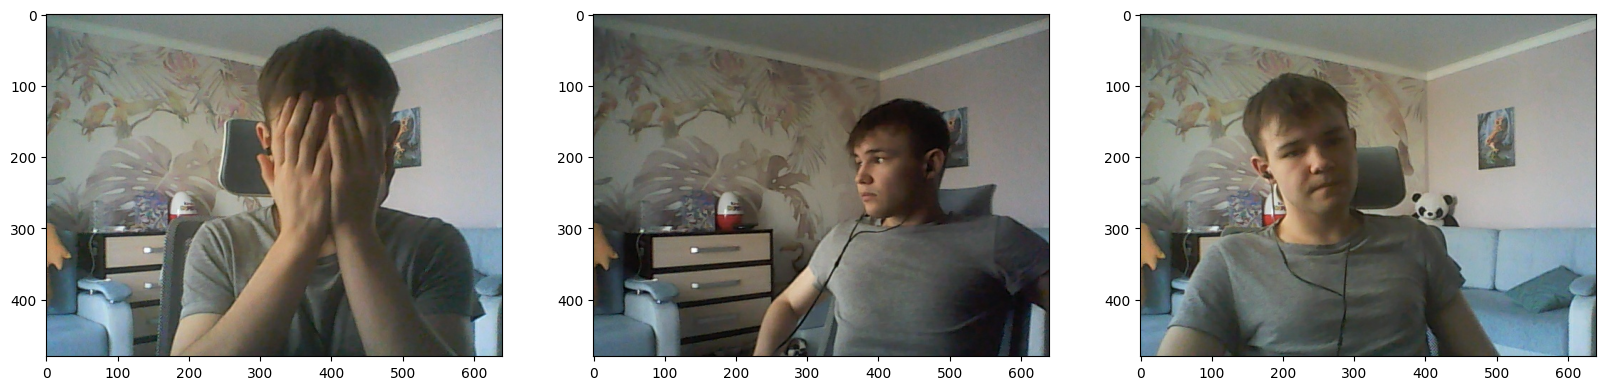

In [34]:
show_images(3)

In [39]:
# 84 train 18 val 18 test

In [10]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.abspath(f'data/labels/{filename}')
        if os.path.exists(existing_filepath):
            new_filepath = os.path.abspath(f'data/{folder}/labels/{filename}')
            os.replace(existing_filepath, new_filepath)

In [3]:
os.path.abspath("data/train")

'D:\\Python\\Jupyter\\Face Detection\\data\\train'

In [3]:
test_image = cv2.imread(os.path.join('data','train','images', '88d4f664-d9a0-11ee-b1f4-36781fb279c0.jpg'))

In [4]:
import albumentations as A

In [5]:
transform = A.Compose([
    A.RandomCrop(width=450, height=450),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.VerticalFlip(p=0.5),
    A.RGBShift(p=0.2),
    A.RandomGamma(p=0.2)],
    bbox_params=A.BboxParams(format='albumentations',
                             label_fields=['class_labels']))

In [6]:
with open(os.path.join('data','train','labels', '88d4f664-d9a0-11ee-b1f4-36781fb279c0.json'), 'r') as f:
    label = json.load(f)

In [8]:
label['shapes'][0]['points']

[[192.25274725274724, 98.79120879120879],
 [355.4395604395604, 303.7362637362637]]

In [19]:
label

{'version': '5.4.1',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[192.25274725274724, 98.79120879120879],
    [355.4395604395604, 303.7362637362637]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {},
   'mask': None}],
 'imagePath': '..\\images\\88d4f664-d9a0-11ee-b1f4-36781fb279c0.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYn

In [9]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [10]:
coords

[192.25274725274724, 98.79120879120879, 355.4395604395604, 303.7362637362637]

In [11]:
coords = list(np.divide(coords, [640, 480, 640, 480]))

In [12]:
coords
# for i in range(len(coords)):
#                 if coords[i] > 1.0:
#                     coords[i] = 1.0

[0.30039491758241754,
 0.2058150183150183,
 0.5553743131868132,
 0.6327838827838828]

In [13]:
augmented = transform(image=test_image, bboxes=[coords], class_labels=['face'])

In [16]:
augmented['bboxes']

[(0.2745787545787547,
  0.18842490842490842,
  0.6372161172161173,
  0.6438583638583638)]

In [36]:
augmented['bboxes'][0][0], augmented['bboxes'][0][3]

(0.36945054945054934, 0.6727472527472527)

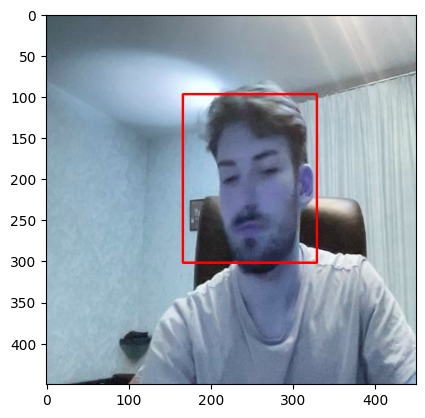

In [37]:
cv2.rectangle(augmented['image'],
             tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
             tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),
             (255,0,0),2)
plt.imshow(augmented['image'])

In [38]:
for folder in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('data', folder, 'images')):
        img = cv2.imread(os.path.join('data', folder, 'images', image))
        
        coords = [0, 0, 0.0001, 0.0001]
        label_path = os.path.join('data', folder, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            coords[0] = min(label['shapes'][0]['points'][0][0], label['shapes'][0]['points'][1][0])
            coords[1] = min(label['shapes'][0]['points'][0][1], label['shapes'][0]['points'][1][1])
            coords[2] = max(label['shapes'][0]['points'][0][0], label['shapes'][0]['points'][1][0])
            coords[3] = max(label['shapes'][0]['points'][0][1], label['shapes'][0]['points'][1][1])
            coords = list(np.divide(coords, [640, 480, 640, 480]))
            
        try:
            for x in range(50):
                augmented = transform(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', folder, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
                
                annotation = {}
                annotation['image'] = image
                
                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0
                with open(os.path.join('aug_data', folder, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)
        except Exception as e:
            print(e)

In [39]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/255)

In [6]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255)

In [78]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/255)

In [40]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [41]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float64]))

In [10]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float64]))

In [79]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float64]))

In [12]:
test_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.51140415, 0.46249084, 0.84717949, 0.77018315]))

In [13]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3430, 3430, 770, 770, 770, 770)

In [42]:
len(train_images), len(train_labels)

(18200, 18200)

In [43]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(20000)
train = train.batch(8)
train = train.prefetch(4)

In [44]:
len(train)

2275

In [15]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(5000)
test = test.batch(8)
test = test.prefetch(4)

In [80]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(5000)
val = val.batch(8)
val = val.prefetch(4)

In [29]:
train.as_numpy_iterator().next()[1]

KeyboardInterrupt: 

In [45]:
train_sample = train.as_numpy_iterator()

In [52]:
res = train_sample.next()

In [53]:
(res[1][1][2] * 120).astype(int)

array([12,  3, 44, 46])

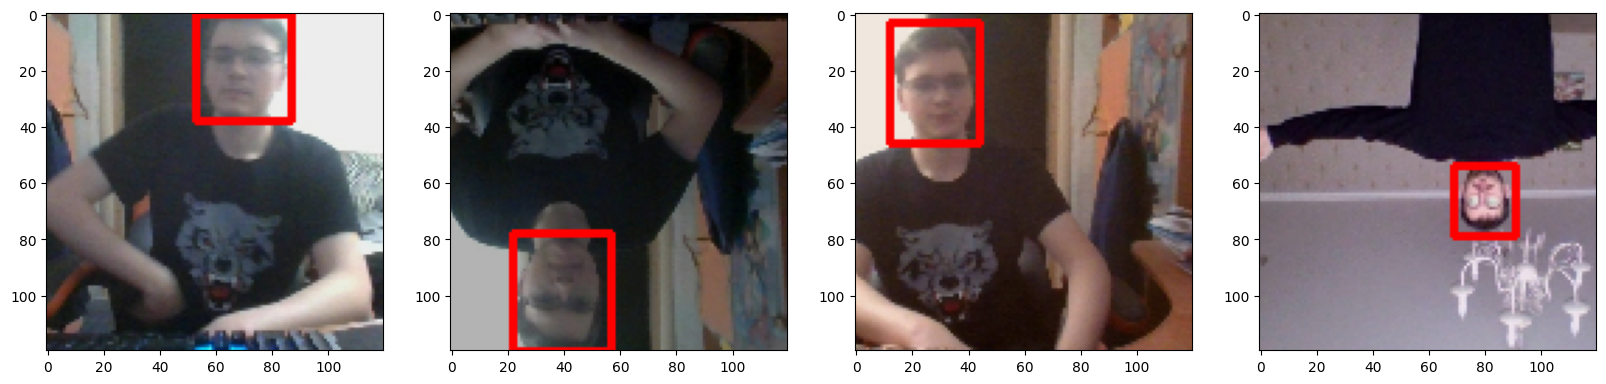

In [54]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = (res[0][idx] * 240).astype(int)
    sample_coords = (res[1][1][idx] * 120).astype(int)
    
    cv2.rectangle(sample_image,
                  sample_coords[:2],
                  sample_coords[2:],
                     (255,0,0),2)
    ax[idx].imshow(sample_image)

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [56]:
vgg = VGG16(include_top=False)

In [57]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [58]:
def build_model():
    input_layer = Input(shape=(120, 120, 3))
    
    vgg = VGG16(include_top=False)(input_layer)
    
    # Classification
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Box
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [59]:
facetracker = build_model()

In [60]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [61]:
X, y = train.as_numpy_iterator().next()

In [62]:
X.shape

(8, 120, 120, 3)

In [63]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 9s 9s/step


In [64]:
classes, coords

(array([[0.51785636],
        [0.41653377],
        [0.46702877],
        [0.47922075],
        [0.53116024],
        [0.6079918 ],
        [0.52687025],
        [0.41761526]], dtype=float32),
 array([[0.6468398 , 0.4801011 , 0.50483906, 0.53925604],
        [0.5569428 , 0.55499005, 0.5624309 , 0.57191604],
        [0.6893766 , 0.4686452 , 0.49493173, 0.6429846 ],
        [0.6842029 , 0.5075476 , 0.5369976 , 0.61764157],
        [0.7066771 , 0.49457797, 0.5879117 , 0.5409324 ],
        [0.7222402 , 0.48029765, 0.59681445, 0.49603862],
        [0.6821704 , 0.45727527, 0.54339343, 0.5443755 ],
        [0.63458556, 0.45326638, 0.5204776 , 0.58499813]], dtype=float32))

In [65]:
len(train)

2275

In [66]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [67]:
lr_decay

0.0001465201465201465

In [68]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [69]:
def localizaztion_loss(y_true, y_pred):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - y_pred[:,:2]))
    
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]
    
    h_pred = y_pred[:,3] - y_pred[:,1]
    w_pred = y_pred[:,2] - y_pred[:,0]
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))
    
    return delta_coord + delta_size

In [70]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localizaztion_loss

In [71]:
localizaztion_loss(y[1],coords).numpy()

6.171451453779302

In [72]:
classloss(y[0], classes).numpy()

0.7093854

In [73]:
class FaceTracker(Model):
    def __init__(self, eyetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker
    
    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.classloss = classloss
        self.localizationloss = localizationloss
        self.opt = opt
        
    def train_step(self, batch, **kwargs):
        
        X, y = batch
        
        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.classloss(y[0], classes)
            batch_localizationloss = self.localizationloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
            
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs):
        
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.classloss(y[0], classes)
        batch_localizationloss = self.localizationloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [74]:
model = FaceTracker(facetracker)

In [75]:
model.compile(opt, classloss, regressloss)

In [76]:
logdir='logs'

In [77]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [81]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40
  39/2275 [..............................] - ETA: 13:29 - total_loss: 1.8759 - class_loss: 0.4952 - regress_loss: 1.6283

KeyboardInterrupt: 

In [46]:
from tensorflow.keras.models import load_model

In [47]:
facetracker.save('facetracker.h5')

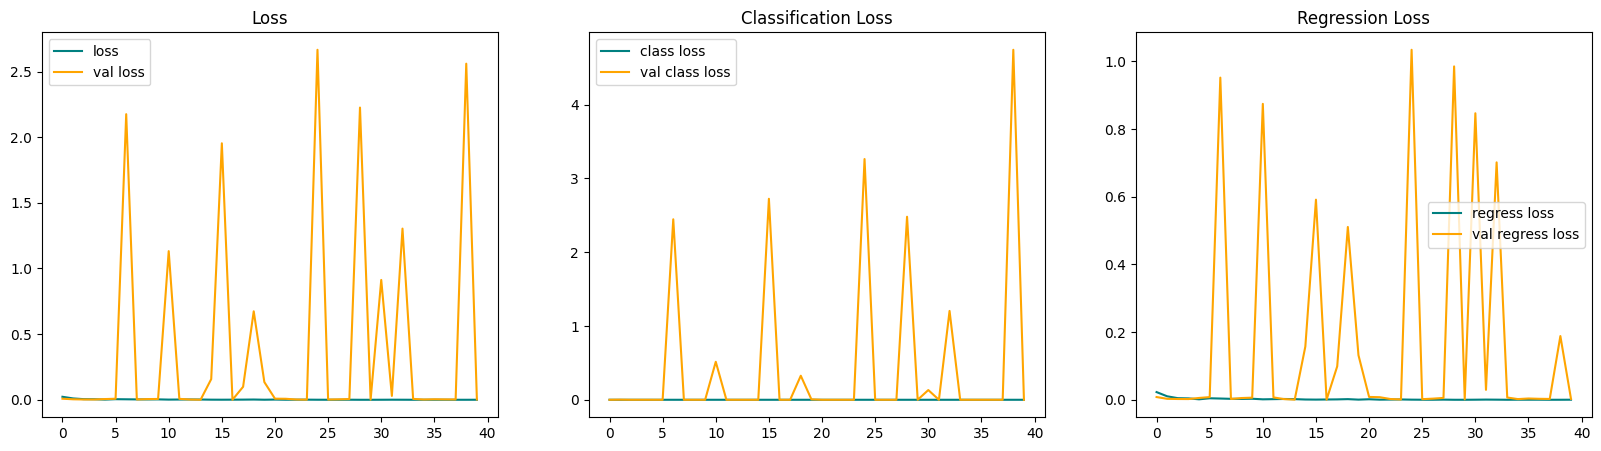

In [51]:

fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [52]:
test_data = test.as_numpy_iterator()

In [64]:
test_sample = test_data.next()

In [69]:
type(test_sample)

tuple

In [65]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 38ms/step


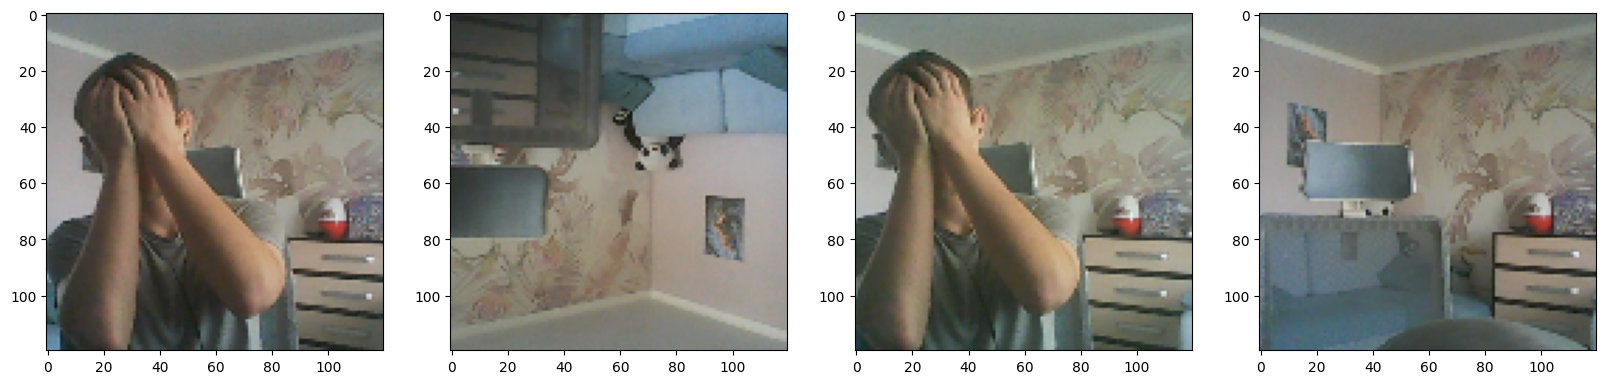

In [66]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = (test_sample[0][idx] * 240).astype(int)
    sample_coords = (yhat[1][idx] * 120).astype(int)
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      sample_coords[:2],
                      sample_coords[2:], 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [67]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


In [13]:
import numpy as np
x = np.random.rand(2, 4, 6, 4)

In [14]:
x.shape

(2, 4, 6, 4)

In [15]:
y = GlobalMaxPooling2D()(x)

In [16]:
y.shape

TensorShape([2, 4])